In [32]:
# Boilerplate
import numpy as np
import pandas as pd
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import time
import os
import warnings
from random import randint
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import ipywidgets as wgt
import importlib

import tmv3_class as tmv3c
importlib.reload(tmv3c)

<module 'tmv3_class' from 'c:\\Users\\jared\\Desktop\\TableMaker\\tmv3_class.py'>

# Table Creation

In [33]:
def createTable():
    # Wrapper function to create a new table. Only needs to be run if a previous
    # table does not exist or if parameters need to be changed.

    ##### Set parameters for the table
    nxim = 150
    ximLfrac = 0.2
    ximGfrac = 0.5
    nxiv = 30

    # Set filepath for flamelet data
    path = r'./data/ChiGammaTablev3'
    file_pattern = r'flm_.*.dat$'

    # Adjust data parameters (change depending on how ignis was run)
    tvals = np.arange(0,14,1)
    Lvals = np.arange(0,26,1)
    gammaValues = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65]
    # Lbounds = [min(Lvals), max(Lvals)] # redundant
    # tbounds = [min(tvals), max(tvals)] # redundant
    path_to_hsens = './data/ChiGammaTablev3/hsens.dat' # Col1: mixf, Col2: hsens (L = 0). 

    tables = tmv3c.table(path, Lvals, tvals, nxim=nxim, nxiv=nxiv, ximLfrac=ximLfrac, ximGfrac=ximGfrac,
                        gammaValues=gammaValues, flmt_file_pattern=file_pattern, path_to_hsens=path_to_hsens)
    
    # Create data if missing (redundant if table already exists)
    print("Creating missing data functions...")
    start = time.time()
    tables.phi_mvhc(['T', 'hr', 'CO', 'OH', 'CO2'])
    end = time.time()
    seconds = int(end - start)
    print(f"Completed. Time elapsed: {seconds//60} minutes {seconds%60} seconds")

    return tables

# # Create table
# tables = createTable()

# # Save table
# name = 'tableclassdata'
# tables.save(name)

In [35]:
# Load previously generated table & data
tables = tmv3c.load('tables')

Table tables was created on 20251017
Table loaded from c:\Users\jared\Desktop\TableMaker\results\tables.pkl

Beginning parallel table creation for phis [].
All tables created. Creating interpolators...
Creating phi(xim, xiv, h, c) functions...
Creating interpolator for phi = T
Creating interpolator for phi = hr
Creating interpolator for phi = CO
Creating interpolator for phi = OH
Creating interpolator for phi = CO2
Recreated functions and interpolators.


In [44]:
# Verify functions are callable and returning reasonable values
print("Confirm functions were generated correctly:")
print(tables.phi_mvhc_funcs['T']  (0.06, 0.005, -1e6, 0.15))
print(tables.phi_mvhc_funcs['hr'] (0.06, 0.005, -1e6, 0.15))
print(tables.phi_mvhc_funcs['CO'] (0.06, 0.005, -1e6, 0.15))
print(tables.phi_mvhc_funcs['OH'] (0.06, 0.005, -1e6, 0.15))
print(tables.phi_mvhc_funcs['CO2'](0.06, 0.005, -1e6, 0.15))

# Aliases for functions
T_func   = tables.phi_mvhc_funcs['T']  
hr_func  = tables.phi_mvhc_funcs['hr'] 
CO_func  = tables.phi_mvhc_funcs['CO'] 
OH_func  = tables.phi_mvhc_funcs['OH'] 
CO2_func = tables.phi_mvhc_funcs['CO2']

Confirm functions were generated correctly:
[1103.05715314]
[23585862.77190429]
[0.00901804]
[0.00017968]
[0.0725403]


# Results

## Single ODT Realization

In [ ]:
#myPath = r'./aPriori/tjet_many2data/data'
#filename = '/data_00001/dmp_00036.dat'
myPath = r'/Users/cougar/jaredporter/inferno/codes/odt/data/tjet_1/data'
filename = r'/data_00010/dmp_00020.dat'
# Check if the file exists
assert os.path.isfile(myPath + filename)

if input("Re-query the table?") == 'y':
    # Load in data
    SORdata = np.loadtxt(myPath + filename)

    # Grab header
    with open(myPath + filename, 'r') as f:
        last_line = None
        for line in f:
            if line[0] == '#':
                last_line = line
    SORheader = last_line.split()[1:]
    SORdf = pd.DataFrame(SORdata, columns = SORheader)
    SORdf['30_progVar'] = SORdf['23_y_CO'] + SORdf['24_y_CO2'] + SORdf['12_y_H2'] + SORdf['17_y_H2O']

    # Replace any negative values in the 9th column with 0
    SORdf['9_mixf'] = SORdf['9_mixf'].apply(lambda x: 0 if x < 0 else x)
    
    # Query table
    SORdf['hr_queried'] = np.zeros(len(SORdf['2_posf']))
    SORdf['temp_queried'] = np.zeros(len(SORdf['2_posf']))
    SORdf['CO_queried'] = np.zeros(len(SORdf['2_posf']))
    SORdf['OH_queried'] = np.zeros(len(SORdf['2_posf']))
    SORdf['CO2_queried'] = np.zeros(len(SORdf['2_posf']))
    for i in range(len(SORdf['2_posf'])):
        xim = SORdf['9_mixf'][i]
        h = SORdf['29_enth'][i]
        c = SORdf['30_progVar'][i]
        # Temporarily suppress warnings
        with warnings.catch_warnings():
            SORdf.loc[i, 'hr_queried'] =   hr_func(xim, 0, h, c, useStoredSolution = False, solver = 'gammaChi')
            SORdf.loc[i, 'temp_queried'] =  T_func(xim, 0, h, c, useStoredSolution = False, solver = 'gammaChi')
            SORdf.loc[i, 'CO_queried'] =   CO_func(xim, 0, h, c, useStoredSolution = False, solver = 'gammaChi')
            SORdf.loc[i, 'OH_queried'] =   OH_func(xim, 0, h, c, useStoredSolution = False, solver = 'gammaChi')
            SORdf.loc[i, 'CO2_queried'] = CO2_func(xim, 0, h, c, useStoredSolution = False, solver = 'gammaChi')
            
        if i%30 == 0:
            print(f"Finished row {i}/{len(SORdf['2_posf'])}")

AssertionError: 

In [316]:
SORdf.columns

Index(['1_pos', '2_posf', '3_rho', '4_dvisc', '5_uvel', '6_vvel', '7_wvel',
       '8_temp', '9_mixf', '10_chi', '11_hr', '12_y_H2', '13_y_H', '14_y_O',
       '15_y_O2', '16_y_OH', '17_y_H2O', '18_y_HO2', '19_y_CH2', '20_y_CH2(S)',
       '21_y_CH3', '22_y_CH4', '23_y_CO', '24_y_CO2', '25_y_HCO', '26_y_CH2O',
       '27_y_CH2OH', '28_y_N2', '29_enth', '30_progVar', 'hr_queried',
       'temp_queried', 'CO_queried', 'OH_queried', 'CO2_queried'],
      dtype='object')

In [ ]:
def plotSingleODT(phi='temp', ylabel = 'Temperature', units = 'K', splity = False, 
                  savepath = './figures/ODT_aPriori/Publication/singleRlz/', min_yval = None):
    # Find ODT data
    ODT_label = None
    queried_label = None
    for item in SORdf.columns:
        last_element = item.split('_')[-1]
        if last_element.lower() == phi.lower():
            ODT_label = item
        if last_element == 'queried' and item.split('_')[-2].lower() == phi.lower():
            queried_label = item
    if ODT_label == None:
        raise ValueError(f"ODT data does not contain {phi}.")
    if queried_label == None:
        raise ValueError(f"Queried unavailable for {phi}.")
    
    # Plot comparison in physical space
    plt.rcParams.update({'font.size': 14})
    plt.plot(SORdf['2_posf'], np.minimum(SORdf[ODT_label], min_yval), 'bo', label = "ODT")
    if splity:
        plt.ylabel(f"ODT {ylabel} ({units})")
        plt.twinx()
    else:
        plt.ylabel(f"{ylabel} ({units})")
    plt.plot(SORdf['2_posf'], np.minimum(SORdf[queried_label], min_yval), 'r.', label = "Queried")
    plt.xlabel("Position (m)")
    plt.legend()
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    plt.tight_layout()
    plt.savefig(savepath + f"{phi}_physicalspace.png", dpi = 300)
    plt.show()

    # Plot comparison in mixture fraction space
    plt.plot(SORdf['9_mixf'], np.minimum(SORdf[ODT_label], min_yval), 'bo', label = "ODT")
    if splity:
        plt.ylabel(f"ODT {ylabel} ({units})")
        plt.twinx()
    else:
        plt.ylabel(f"{ylabel} ({units})")
    plt.plot(SORdf['9_mixf'], np.minimum(SORdf[queried_label], min_yval), 'r.', label = "Queried")
    plt.xlabel("Mixture Fraction")
    #plt.xlim(-0.05,1.05)
    plt.legend()
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    plt.tight_layout()
    plt.savefig(savepath + f"{phi}_mixfspace.png", dpi = 300)
    plt.show()

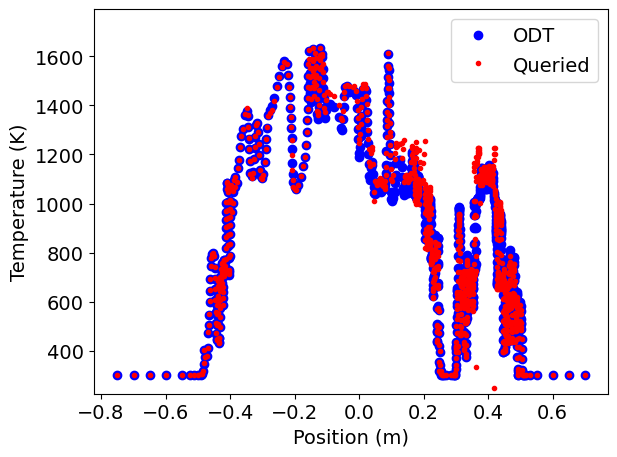

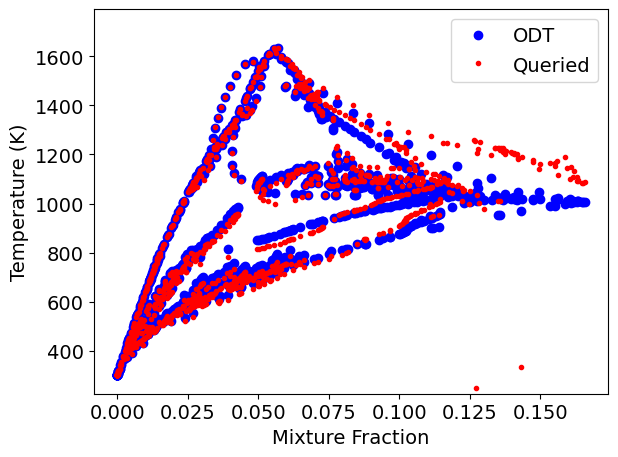

In [ ]:
plotSingleODT('temp', ylabel = 'Temperature', units = 'K')

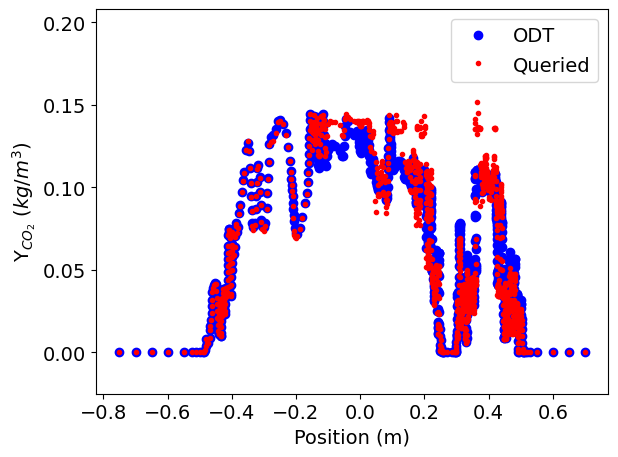

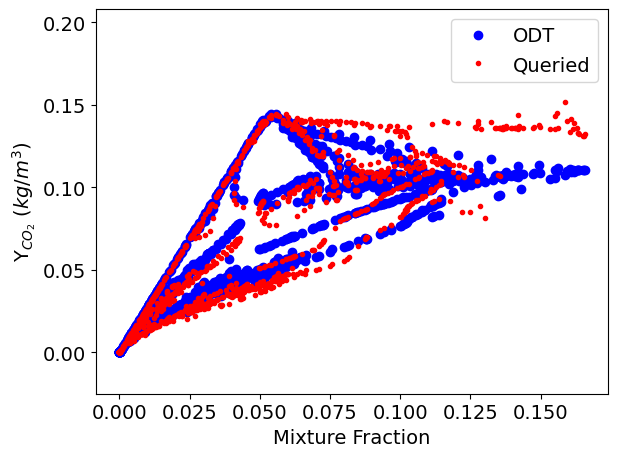

In [319]:
plotSingleODT('CO2', ylabel = r'Y$_{CO_2}$', units = r'$kg/m^3$', ylim = (-0.025,None))

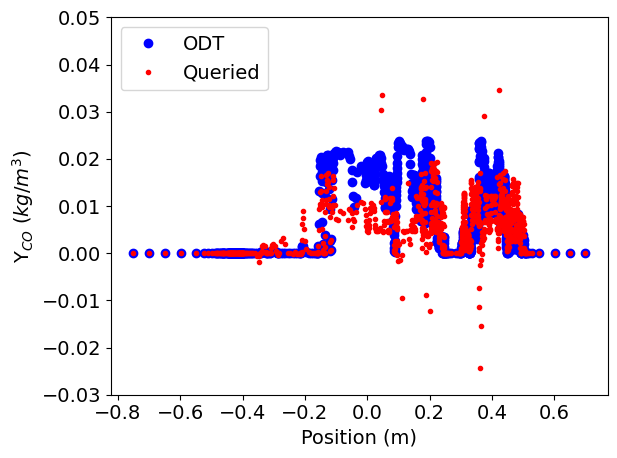

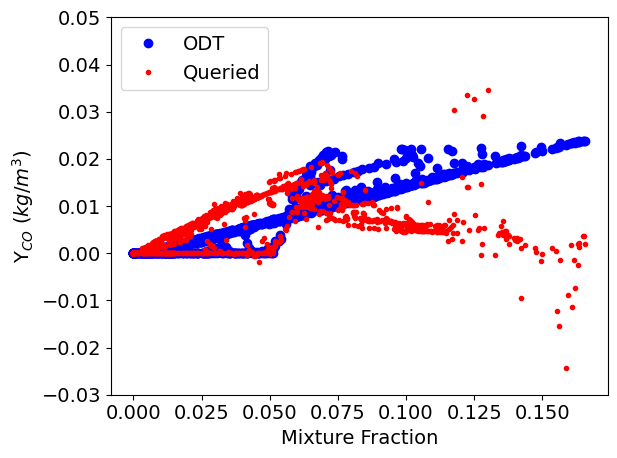

In [320]:
plotSingleODT('CO', ylabel = r'Y$_{CO}$', units = r'$kg/m^3$', ylim = (-0.03, 0.05))

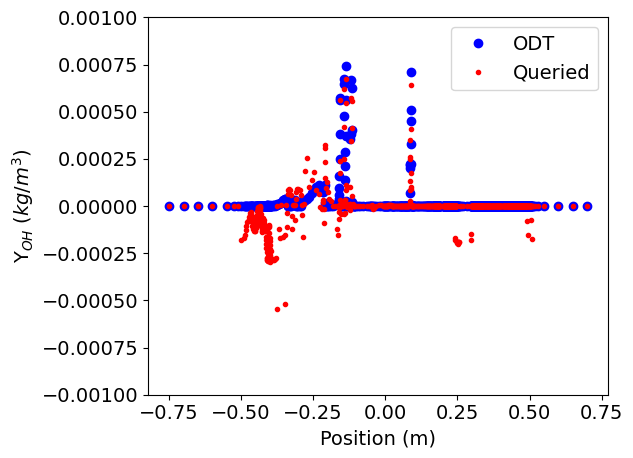

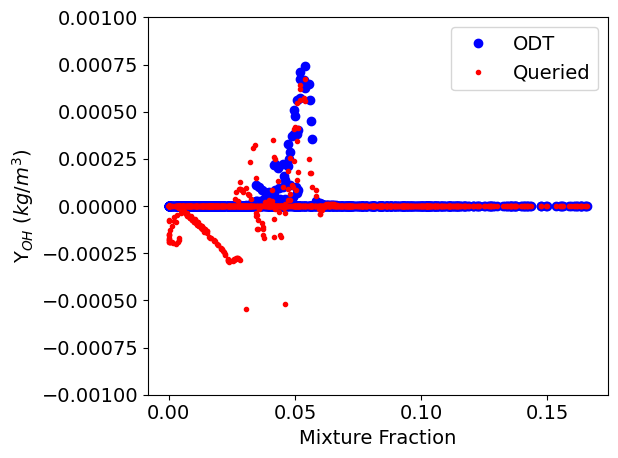

In [321]:
plotSingleODT('OH', ylabel = r'Y$_{OH}$', units = r'$kg/m^3$', ylim = [-0.001, 0.001])

## Scatter Plot for each ODT case

In [117]:
def plotODTScatter(caseName, phicol, phi, units, mixfcol = 8, posfcol = 2, savepath = './figures/ODT_aPriori/Publication/scatters', 
                   plotPhysicalSpace = False):
    if type(caseName) == type('str'):
        caseName = [caseName,]
    for case in caseName:
        dir = r'../../odt/data/tjet_Le1B_'+case+r'/data'
        rlzs = ['data_00003', 'data_00004', 'data_00005', 'data_00006']
        times = ['dmp_00001', 'dmp_00005', 'dmp_00010', 'dmp_00015', 'dmp_00020', 'dmp_00025', 'dmp_00030', 'dmp_00035', 'dmp_00036']
        data = np.array([None,None])

        # Load in data
        point = 0
        for i in range(len(rlzs)):
            for j in range(len(times)):
                filename = f'/{rlzs[i]}/{times[j]}.dat'
                # Check if the file exists
                assert os.path.isfile(dir + filename)
                # Load the data
                datafile = np.loadtxt(dir + filename)
                new_data = datafile[:, [posfcol, mixfcol, phicol]]
                if (data == None).any():
                    data = new_data.copy()
                else:
                    data = np.vstack((data, new_data))
        
        # Plot scatter in mixture fraction space
        plt.rcParams.update({'font.size': 14})
        plt.scatter(data[:,1], data[:,2], cmap = 'inferno', c = data[:,2], s = 0.2)
        plt.xlabel('Mixture Fraction')
        plt.ylabel(f'{phi} ({units})')
        plt.text(0.9, 0.9, f'{case}', fontsize = 14, ha = 'right', va = 'top', transform=plt.gca().transAxes)
        plt.savefig(savepath + f'{case}_{phi}_mixfspace.pdf', dpi = 300)
        plt.show()

        if plotPhysicalSpace:
            # Plot scatter in physical space
            plt.scatter(data[:,0], data[:,2], cmap = 'inferno', c = data[:,2], s = 0.2)
            plt.xlabel('Position (m)')
            plt.ylabel(f'{phi} ({units})')
            plt.gca().set_aspect('equal')
            plt.savefig(savepath + f'{case}_{phi}_physicalspace.pdf', dpi = 300)
            plt.show()

# Columns of interest:
# 2 - Position
# 8 - Mixture fraction
# 7 - Temperature
# 10 - heat rate
# 15 - OH
# 22 - CO
# 23 - CO2
# 28 - enthalpy

In [118]:
# Columns of interest:
# 2 - Position
# 8 - Mixture fraction
# 7 - Temperature
# 10 - heat rate
# 15 - OH
# 22 - CO
# 23 - CO2
# 28 - enthalpy
plotODTScatter(['HGHE','HGLE', 'LGHE'], 7, 'T', 'K')

AssertionError: 

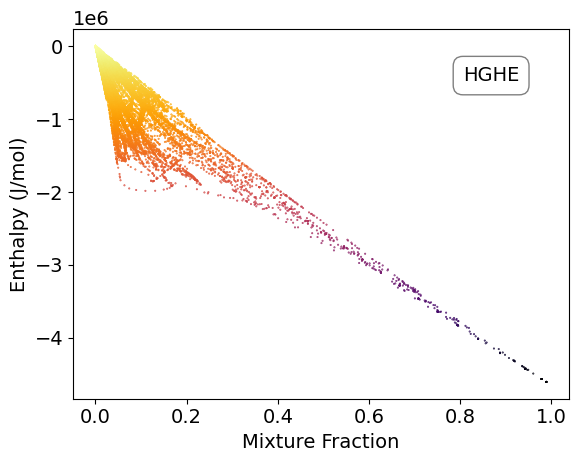

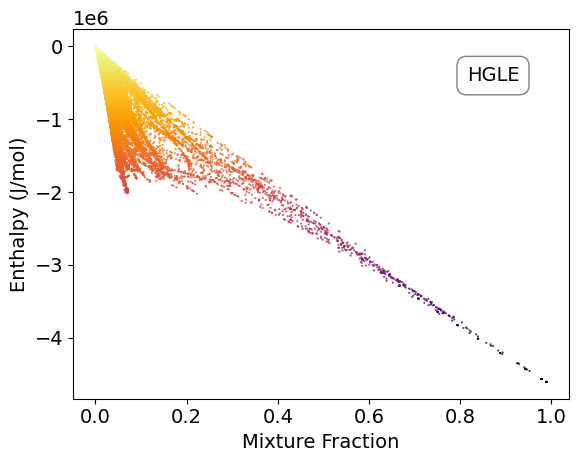

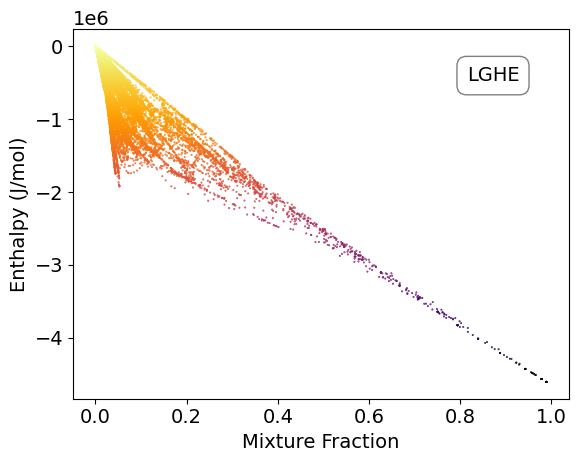

In [150]:
# Columns of interest:
# 2 - Position
# 8 - Mixture fraction
# 7 - Temperature
# 10 - heat rate
# 15 - OH
# 22 - CO
# 23 - CO2
# 28 - enthalpy
plotODTScatter(['HGHE','HGLE', 'LGHE'], 28, 'Enthalpy', r'J/mol')

## T(Z; vary $\gamma$), T(Z; vary $\zeta$)

<>:30: SyntaxWarning: invalid escape sequence '\h'
<>:30: SyntaxWarning: invalid escape sequence '\z'
<>:42: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\h'
<>:30: SyntaxWarning: invalid escape sequence '\z'
<>:42: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\g'
C:\Users\jared\AppData\Local\Temp\ipykernel_7244\195947820.py:30: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(varyzeta[i][:,0], varyzeta[i][:,1], label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
C:\Users\jared\AppData\Local\Temp\ipykernel_7244\195947820.py:30: SyntaxWarning: invalid escape sequence '\z'
  plt.plot(varyzeta[i][:,0], varyzeta[i][:,1], label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
C:\Users\jared\AppData\Local\Temp\ipykernel_7244\195947820.py:42: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(varygamma[i][:,0], varygamma[

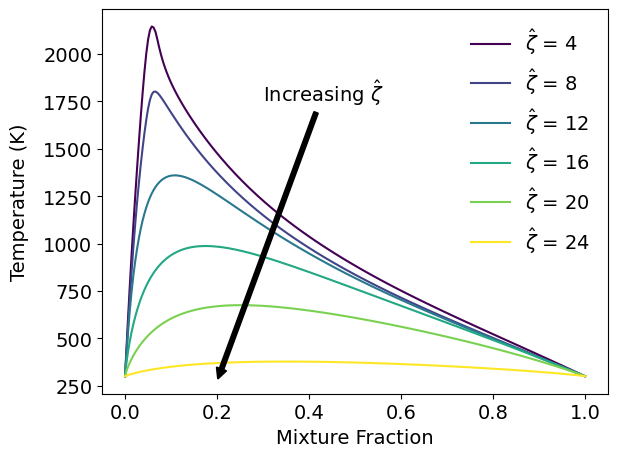

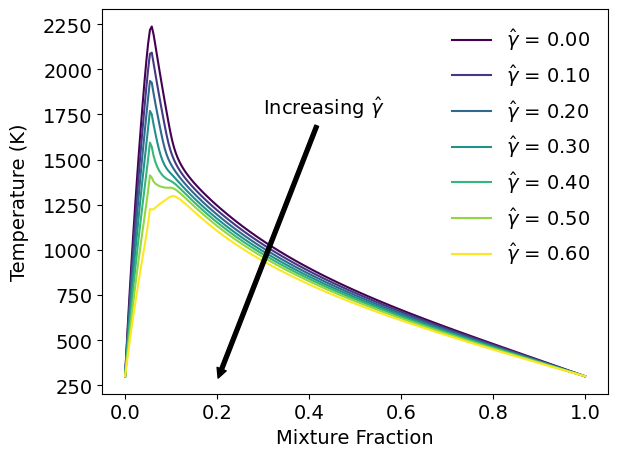

In [17]:
path = r'./data/ChiGammaTablev3/'
savepath = r'./figures/ODT_aPriori/Publication/'

zetas = np.arange(4,26,4, dtype = int)
gammas = np.arange(0,14,2, dtype = int)
gammaLabels = np.arange(0,0.66, 0.1)

mixfcol = 1 # Mixture fraction
phicol = 2 # Temperature (K)

varyzeta = []

plt.rcParams.update({'font.size': 14})

for i in range(len(zetas)):
    data = np.loadtxt(path + f"flm_{zetas[i]:02}_00.dat")
    varyzeta.append(data[:,[mixfcol, phicol]])

varygamma = []

for i in range(len(gammas)):
    data = np.loadtxt(path + f"flm_00_{gammas[i]:02}.dat")
    varygamma.append(data[:,[mixfcol, phicol]])

# Plot varying zeta
cmap = plt.get_cmap('viridis')

zetacolors = [cmap(i) for i in np.linspace(0, 1, len(zetas))]
for i in range(len(zetas)):
    plt.plot(varyzeta[i][:,0], varyzeta[i][:,1], label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
plt.xlabel('Mixture Fraction')
plt.ylabel('Temperature (K)', labelpad=10)
plt.annotate(r'Increasing $\hat{\zeta}$', xy=(0.2, 275), xytext=(0.3, 1750), arrowprops=dict(arrowstyle='simple', lw=1.5, facecolor='black', ))
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(savepath + 'T_varyZeta.pdf', dpi = 300, bbox_inches='tight')
plt.show()

# Plot varying gamma
gammacolors = [cmap(i) for i in np.linspace(0, 1, len(gammas))]
for i in range(len(gammas)):
    plt.plot(varygamma[i][:,0], varygamma[i][:,1], label = f'$\hat{{\gamma}}$ = {gammaLabels[i]:.2f}', color = gammacolors[i])
plt.xlabel('Mixture Fraction')
plt.ylabel('Temperature (K)', labelpad=10)
plt.annotate(r'Increasing $\hat{\gamma}$', xy=(0.2, 275), xytext=(0.3, 1750), arrowprops=dict(arrowstyle='simple', lw=1, facecolor='black', ))
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(savepath + 'T_varyGamma.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## c(Z; vary $\gamma$), c(Z; vary $\zeta$)

<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\z'
<>:42: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\z'
<>:42: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\g'
C:\Users\jared\AppData\Local\Temp\ipykernel_18044\694212087.py:29: SyntaxWarning: invalid escape sequence '\h'
  label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
C:\Users\jared\AppData\Local\Temp\ipykernel_18044\694212087.py:29: SyntaxWarning: invalid escape sequence '\z'
  label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
C:\Users\jared\AppData\Local\Temp\ipykernel_18044\694212087.py:42: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(varygamma[i][:,0], varygamma[i][:,1], label = f'$\hat{{\gamma}}$ = {gammaLabels[i]:.2f}', color = gammacolors[i])
C:

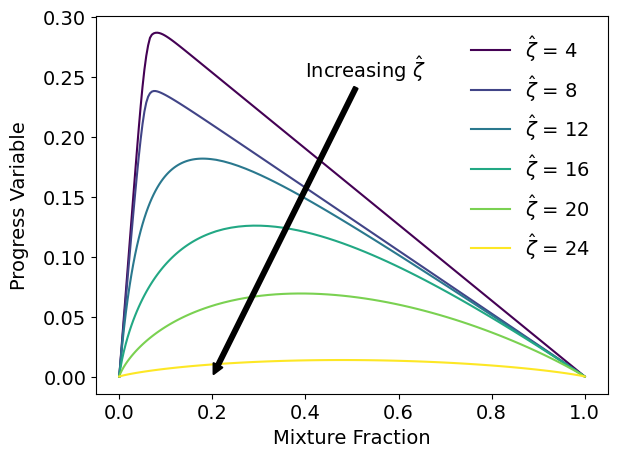

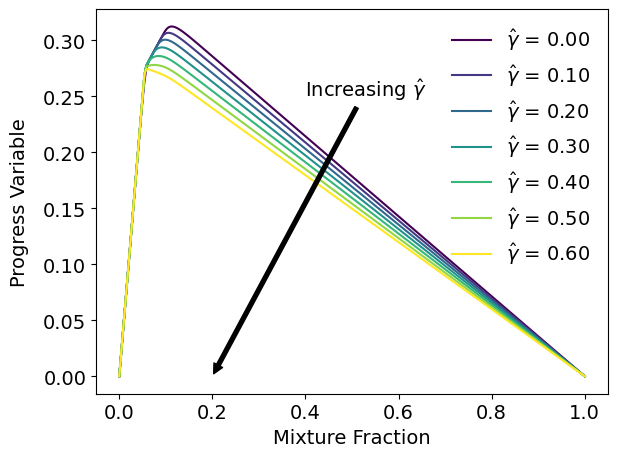

In [40]:
path = r'./data/ChiGammaTablev3/'
savepath = r'./figures/ODT_aPriori/Publication/'

zetas = np.arange(4,26,4, dtype = int)
gammas = np.arange(0,14,2, dtype = int)
gammaLabels = np.arange(0,0.66, 0.1)

mixfcol = 1 # Mixture fraction
phicol  = 4 # Progress variable (CO2+CO+H2+H2O)

varyzeta = []

for i in range(len(zetas)):
    data = np.loadtxt(path + f"flm_{zetas[i]:02}_00.dat")
    varyzeta.append(data[:,[mixfcol, phicol]])

varygamma = []

for i in range(len(gammas)):
    data = np.loadtxt(path + f"flm_00_{gammas[i]:02}.dat")
    varygamma.append(data[:,[mixfcol, phicol]])

# Plot varying zeta
cmap = plt.get_cmap('viridis')

zetacolors = [cmap(i) for i in np.linspace(0, 1, len(zetas))]
for i in range(len(zetas)):
    plt.plot(varyzeta[i][:,0], varyzeta[i][:,1], 
             label = f'$\hat{{\zeta}}$ = {zetas[i]}', color = zetacolors[i])
plt.xlabel('Mixture Fraction')
plt.ylabel('Progress Variable', labelpad=10)
plt.annotate(r'Increasing $\hat{\zeta}$', xy=(0.2, 0), 
             xytext=(0.4, 0.25), arrowprops=dict(arrowstyle='simple', lw=1.5, facecolor='black', ))
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(savepath + 'c_varyZeta.pdf', dpi = 300, bbox_inches='tight')
plt.show()

# Plot varying gamma
gammacolors = [cmap(i) for i in np.linspace(0, 1, len(gammas))]
for i in range(len(gammas)):
    plt.plot(varygamma[i][:,0], varygamma[i][:,1], label = f'$\hat{{\gamma}}$ = {gammaLabels[i]:.2f}', color = gammacolors[i])
plt.xlabel('Mixture Fraction')
plt.ylabel('Progress Variable', labelpad=10)
plt.annotate(r'Increasing $\hat{\gamma}$', xy=(0.2, 0), xytext=(0.4, 0.25), arrowprops=dict(arrowstyle='simple', lw=1, facecolor='black', ))
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(savepath + 'c_varyGamma.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## 3D Contour: T(gamma, zeta)

C:\Users\jared\AppData\Local\Temp\ipykernel_23168\3915749318.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts[i, j] = TInterp(ximT, xivT, xT[i, j], yT[i, j])


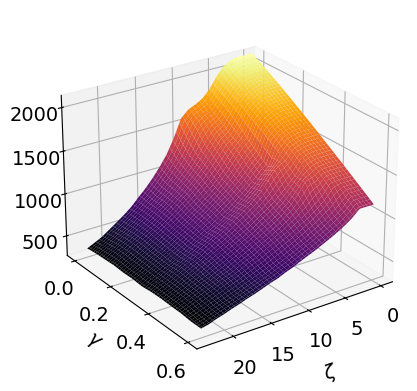

In [13]:
# Generate data
ximT = 0.05
xivT = 0.000
num_points = 100
zetas = np.linspace(1e-4, 23-1e-4, num_points)
gammas = np.linspace(1e-4, 12-1e-4, num_points)
gammalabels = gammas*0.05

xT, yT = np.meshgrid(zetas, gammas)
xT2, yT2 = np.meshgrid(zetas, gammalabels)
Ts = np.zeros_like(xT)

phi = "temp"
for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = TInterp(ximT, xivT, xT[i, j], yT[i, j])

# Plot data
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xT2, yT2, zdata, cmap='inferno')
ax.set_zlabel("Temperature (K)", labelpad = 15, rotation = 180)
ax.set_xlabel(r"$\zeta$", labelpad = 10)
ax.set_ylabel(r"$\gamma$")
ax.view_init(25, 55)
ax.set_zlim(bottom=300, top=2100)

plt.savefig(f'./figures/ODT_aPriori/Publication/GZ_contours/{phi}_z_{ximT:.2g}_var_{xivT:.2g}_zgcontour.pdf',dpi=300)
plt.show()

## 3D Contour: T(Z, Z''2)

C:\Users\jared\AppData\Local\Temp\ipykernel_23168\2031932867.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ts[i, j] = TInterp(meanij, yT[i,j]*maxvar, gammaT, zetaT)


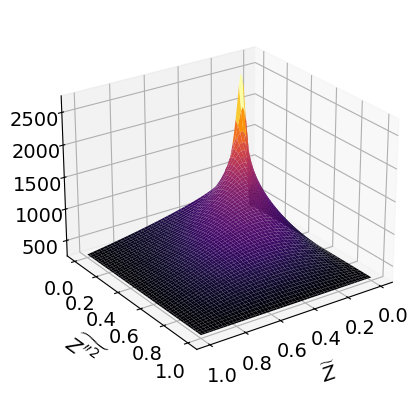

In [32]:
# Generate data
gammaT = 12 # (0, 13)
zetaT  = 22  # (0, 23)
num_points = 100
means = np.linspace(0, 1, num_points)
relvars = np.linspace(0, 1, num_points)

xT, yT = np.meshgrid(means, relvars)
Ts = np.zeros_like(xT)

phi = "temp"
for i in range(num_points):
    for j in range(num_points):
        meanij = xT[i,j]
        maxvar = meanij*(1-meanij)
        Ts[i, j] = TInterp(meanij, yT[i,j]*maxvar, gammaT, zetaT)

# Plot data
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.set_zlabel("Temperature (K)", labelpad = 15, rotation = 180)
ax.set_xlabel(r"$\widetilde{Z}$", labelpad = 10)
ax.set_ylabel(r"$\widetilde{Z''^2}$", labelpad = 10)
ax.view_init(25, 55)
ax.set_zlim(bottom=300, top=2700)

plt.savefig(f'./figures/ODT_aPriori/Publication/MV_contours/{phi}_g_{gammaT*0.05:.2g}_z_{zetaT:.2g}_mvcontour.pdf',dpi=300)
plt.show()

## Compare T_func to table values
Sanity check

In [ ]:
numCompares = 20
ximLen = len(h_indices[0])
xivLen = len(h_indices[1])
LLen   = len(h_indices[2])
tLen   = len(h_indices[3])

cases = {}
Tcomputed = 0
for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1)
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices[0][ximInd]
    xivreal = h_indices[1][xivInd]*ximreal*(1-ximreal)
    Lreal = h_indices[2][LInd]
    treal = h_indices[3][tInd]
    hreal = h_table[ximInd][xivInd][LInd][tInd]
    creal = c_table[ximInd][xivInd][LInd][tInd]
    Treal = T_table[ximInd][xivInd][LInd][tInd]
    warningThrown = False
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        T_computed = T_func(ximreal, xivreal, hreal, creal, useStoredSolution = False, 
                                LstepParams = [0.2, 0.01, 0.004], tstepParams = [0.2, 10.1, 0.02], maxIter = 1000, 
                                solver = 'gammaChi', path_to_hsens = './data/ChiGammaTablev3/hsens.dat', 
                                gammaValues = gammaValues)
        if w:
            #print(w)
            warningThrown = True

    cases[i] = [ximreal, xivreal, hreal, creal, Lreal, treal, Treal, T_computed[0], ""]
    if np.abs(T_computed-Treal) > 1:
        cases[i][-1] = "T Mismatch"
    if warningThrown:
        cases[i][-1] = "Solver didn't converge"

df = pd.DataFrame(cases, index = ["xim", "xiv", "h", "c", "L", "t", "T", "Tcomputed", "warning"]).T
pd.set_option('display.float_format', '{:.5g}'.format)
df = df.sort_values(by='xim')
df

,xim,xiv,h,c,L,t,T,Tcomputed,warning
19,0.010811,0.0011063,-1.4007e+05,0.0154,24,6,344.02,375.35,T Mismatch
10,0.010811,0.0033188,-88631,0.0084716,23,6,327.91,348.69,T Mismatch
5,0.02973,0.01691,-1.6541e+05,0.016463,6,4,384.72,396.3,T Mismatch
11,0.051351,0.018478,-3.2673e+05,0.048034,8,4,551.29,585.69,T Mismatch
13,0.054054,0.026448,-4.3705e+05,0.036127,11,12,417.22,502.45,T Mismatch
18,0.067568,0.030415,-3.3308e+05,0.024364,17,1,434.16,446.1,T Mismatch
16,0.07027,0.065332,-3.2469e+05,0,16,0,300,300,
4,0.072973,0.044321,-4.1451e+05,0.019043,23,6,363.7,406.69,T Mismatch
15,0.078378,0,-4.7771e+05,0.17505,11,1,1383.8,1383.8,
1,0.11622,0.010625,-5.3824e+05,0.15147,11,0,1228.4,1228.4,


# Solver visualizations

In [115]:
def createPlotData(xim, xiv, Ih, Ic, zetabounds, gammabounds, num_points = 100):
    """Creates h and c data for a given:
        xim = mean mixture fraction
        xiv = mixture fraction variance. 
            NOTE: The maximum allowable variance is determined by the mean:
                xiv_max = xim*(1-xim)
        Ih = interpolator for h(xim, xiv, L, t)
        Ic = interpolator for c(xim, xiv, L, t)
            NOTE: both of these interpolators can readily be created with tm2.createInterpolator
        zetabounds = 2-element array-like containing bounds for zeta
        gammabounds = 2-element array-like containing bounds for gamma
        num_points = Resolution of the grid on each axis.
    Returns:
        [zetas, gammas, hs, cs], where
            xs = 2D meshgrid array of zeta, gamma values (x when plotting in 3D)
            ys = 2D meshgrid array of gamma, zeta values (y when plotting in 3D)
            hs = 2D array of h(zeta, gamma)
            cs = 2D array of c(zeta, gamma)
    """
    num_points = 100
    zetas = np.linspace(min(zetabounds)+1e-4, max(zetabounds)-1e-4, num_points)
    gammas = np.linspace(min(gammabounds)+1e-4, max(gammabounds)-1e-4, num_points)

    xs, ys = np.meshgrid(zetas, gammas)
    hs = np.zeros_like(xs)
    cs = np.zeros_like(xs)

    for i in range(num_points):
        for j in range(num_points):
            hs[i, j] = Ih(xim, xiv, xs[i, j], ys[i, j])[0]
            cs[i, j] = Ic(xim, xiv, xs[i, j], ys[i, j])[0]

    return [xs, ys, hs, cs, xim, xiv]

def plotHCZG(hknown, cknown, xs, ys, hs, cs, xim, xiv, zetabounds, gammabounds, scatterData = None,
             save:bool = True, figsize = (20,20), nameAddition = None, 
             fontscalar = 1.5, fig = None, zetatickSpacing = 0.05):
    """Creates a 3D plot of h(L, t) and c(L, t), as well as a 2D plot showing the
    contour plots of hknown and cknown. The objective is to show visually the space
    within which a given instance of the NewtonSolver in tableMakerv2 is working.
    Inputs:
        hknown = desired value of enthalpy
        cknown = desired value of progress variable
        xs = 1st array returned from createPlotData
        ys = 2nd array returned from createPlotData
        hs = 3rd array returned from createPlotData
        cs = 4th array returned from createPlotData
        xim = 5th output returned from createPlotData (mean mixture fraction)
        xiv = 5th output returned from createPlotData (mixture fraction variance)
        zetabounds = 2-element array-like containing bounds for zeta
        gammabounds = 2-element array-like containing bounds for gamma
        scatterData = array of points to show on the (zeta, gamma) plot
        save:bool = If set to False, the plot will not be saved as a png, only displayed.
        figsize = (width, height) of the plot in inches. May be set to 'None'
        nameAddition = string to be appended to file name.
        fontscalar = multiplier to control font size. The default value is 1.5, meaning the 
            plot will have a fontsize 1.5x that of the matplotlib default.
        fig = matplotlib figure object. Used for animation.
        zetatickSpacing = Spacing between zeta ticks on the plot. Default is 0.05
    Outputs:
        None
    """
    #----- General Formatting
    if fig is None:
        fig = plt.figure(figsize = figsize)
    if fig is not None:
        fig.clf()
    ccol = 'r'  # Color of the progress variable contour
    hcol = 'b'  # Color of the enthalpy contour
    alpha = 0.7 # Surface transparency
    fontsize = int(10*fontscalar)
    plt.rcParams.update({'font.size': fontsize})  # Global font size update
    pad = fontsize/15.*10

    #----- Plot Progress Variable
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(xs,ys,cs, cmap='viridis', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, linestyles = 'dashed')
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title(r"Progress Variable ($\zeta, \gamma$)")
    ax.text2D(0.5, 0.95, f'Contour: c* = {cknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel(r"$\zeta$", labelpad = pad)
    ax.set_xticks(np.arange(min(zetabounds), max(zetabounds)+0.01, zetatickSpacing))
    ax.set_xlim(zetabounds)
    ax.set_ylabel("$\gamma$", labelpad = pad)
    ax.set_zlabel("c", labelpad = 2*pad)
    ax.tick_params(axis='z', pad = 10)
    ax.view_init(15, 110)
    ax.text(ax.get_xlim()[0]*2.5, ax.get_ylim()[0], ax.get_zlim()[1]*1.3,
            f"xim = {xim:.3g}\nxiv = {xiv:.3g}", bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle='round'))
    
    #----- Plot Enthalpy
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(xs, ys, hs, cmap='inferno', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, linestyles = 'dashed')
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title(r"Enthalpy ($\zeta, \gamma$)")
    ax.text2D(0.5, 0.95, f'Contour: h* = {hknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel(r"$\zeta$", labelpad=10)
    ax.set_xticks(np.arange(min(zetabounds), max(zetabounds)+0.01, zetatickSpacing))
    ax.set_xlim(zetabounds)
    ax.set_ylabel(r"$\gamma$", labelpad = pad)
    ax.set_zlabel(r"h", labelpad = 2*pad, rotation = 0)
    ax.tick_params(axis='z', pad = 10)
    ax.ticklabel_format(axis = 'z', style = 'sci', useMathText = True, scilimits = (-1, 1))
    ax.zaxis.get_offset_text().set_visible(False)
    exponent = int(f'{np.min(hs):.2e}'.split('e')[1])
    zlim = ax.get_zlim()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0]*1.5, ylim[0], zlim[1] + (zlim[1]-zlim[0])/6,
            '$\\times\\mathdefault{10^{%d}}\\mathdefault{}$' % exponent)
    ax.view_init(15, 110)

    #----- Plot Projections Only
    ax = fig.add_subplot(133)

    #Get projection data
    ax.contour(xs, ys, cs, levels = [cknown], colors = ccol, linestyles = 'solid')
    ax.contour(xs, ys, hs, levels = [hknown], colors = hcol, linestyles = 'solid')
    if scatterData is not None:
        try:
            xDat = np.array(scatterData)[:,0]
            yDat = np.array(scatterData)[:,1]
            scat, = ax.plot(xDat, yDat, '*', color = 'black', label = "Solver")
        except Exception as e:
            print(e)
            raise ValueError("Could not plot scatter data. Ensure data array is formatted correctly")
    ax.set_title("h & c contours")
    ax.set_xlabel(r"$\zeta$", labelpad = pad)
    ax.set_xticks(np.arange(min(zetabounds), max(zetabounds)+0.01, zetatickSpacing))
    ax.set_xlim(Lbounds)
    ax.set_ylabel(r"$\gamma$", rotation = 0, labelpad = pad)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_box_aspect(1)
    ax.invert_xaxis()
    ax.invert_yaxis()
    legend_elements = [
        Line2D([0], [0], color=ccol, label="Progress Variable (c)"),
        Line2D([0], [0], color=hcol, label="Enthalpy (h)"),
    ]
    if scatterData is not None:
        legend_elements.append(scat)

    #----- Add legend with the proxy artists
    ax.legend(handles=legend_elements, loc = 'upper left', frameon = False)

    #----- Save and show final result
    plt.tight_layout(pad = 5)
    if save:
        if nameAddition is not None:
            addition = f"_{nameAddition}"
        else:
            addition = ""
        plt.savefig(f'HCZG_c_{cknown:.4g}_h_{hknown:.4g}{addition}.png',bbox_inches='tight')  # Save as a PNG file

<>:90: SyntaxWarning: invalid escape sequence '\g'
<>:90: SyntaxWarning: invalid escape sequence '\g'
C:\Users\jared\AppData\Local\Temp\ipykernel_18044\3096201156.py:90: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel("$\gamma$", labelpad = pad)


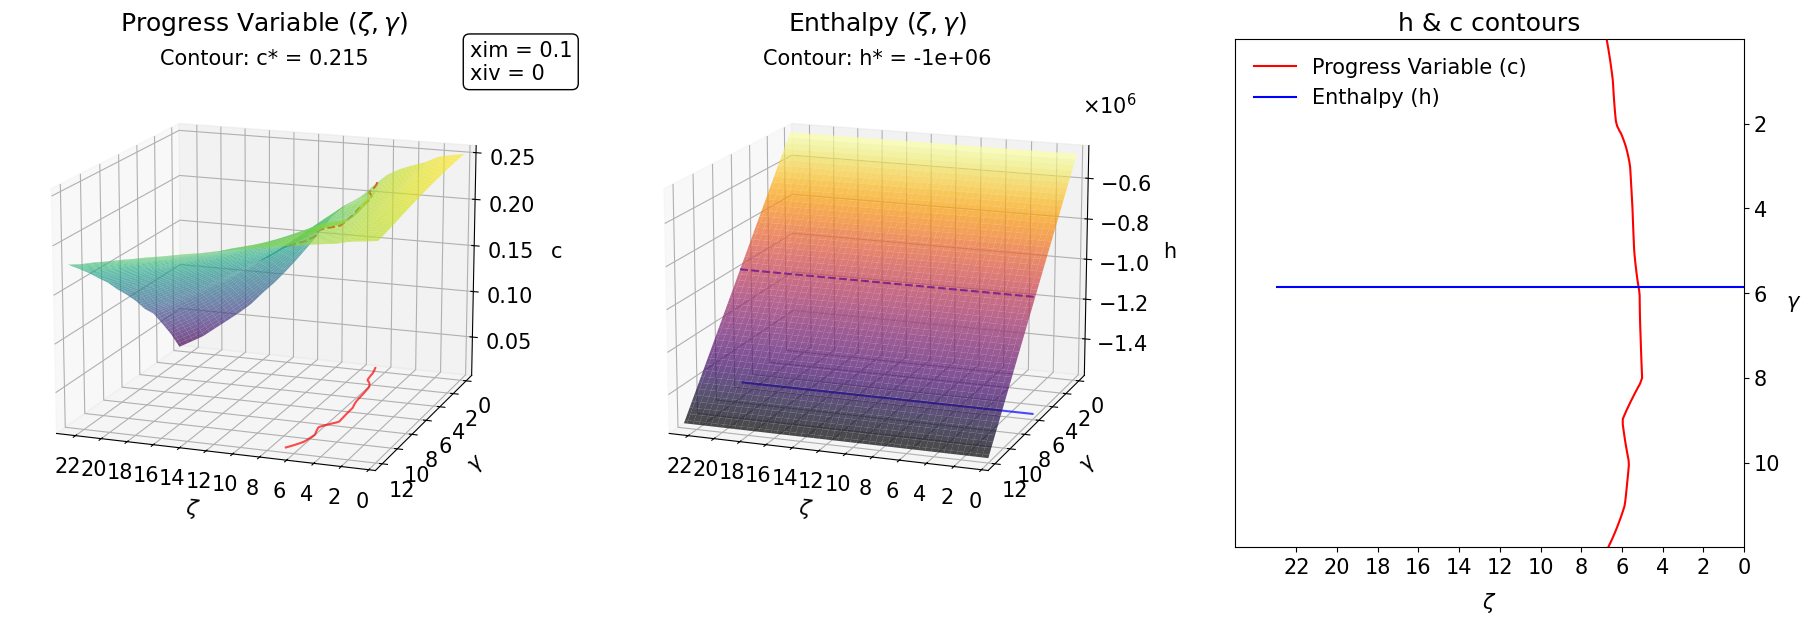

In [116]:
gammavals = np.arange(0,13,1)
zetavals = np.arange(0,24,1)
zetabounds = [min(zetavals), max(zetavals)]
gammabounds = [min(gammavals), max(gammavals)]
hInterp = create_interpolator_mvlt(h_table, h_indices)
cInterp = create_interpolator_mvlt(c_table, c_indices)

zetas, gammas, hs, cs, xim, xiv = createPlotData(0.1, 0.005, hInterp, cInterp, zetabounds, gammabounds)
plotHCZG(-1e6, 0.215, zetas, gammas, hs, cs, 0.1, 0, zetabounds, gammabounds, save =  False, zetatickSpacing = 2)

## Plotting the Contours

Indices:
Radial: 512
Time  : 0

Result:
xim = 0.122
xiv = 0.00375
h   = -1.22e+06
c   = 0.163
T_table = 887.7 K
T_ODT   = 948.1 K


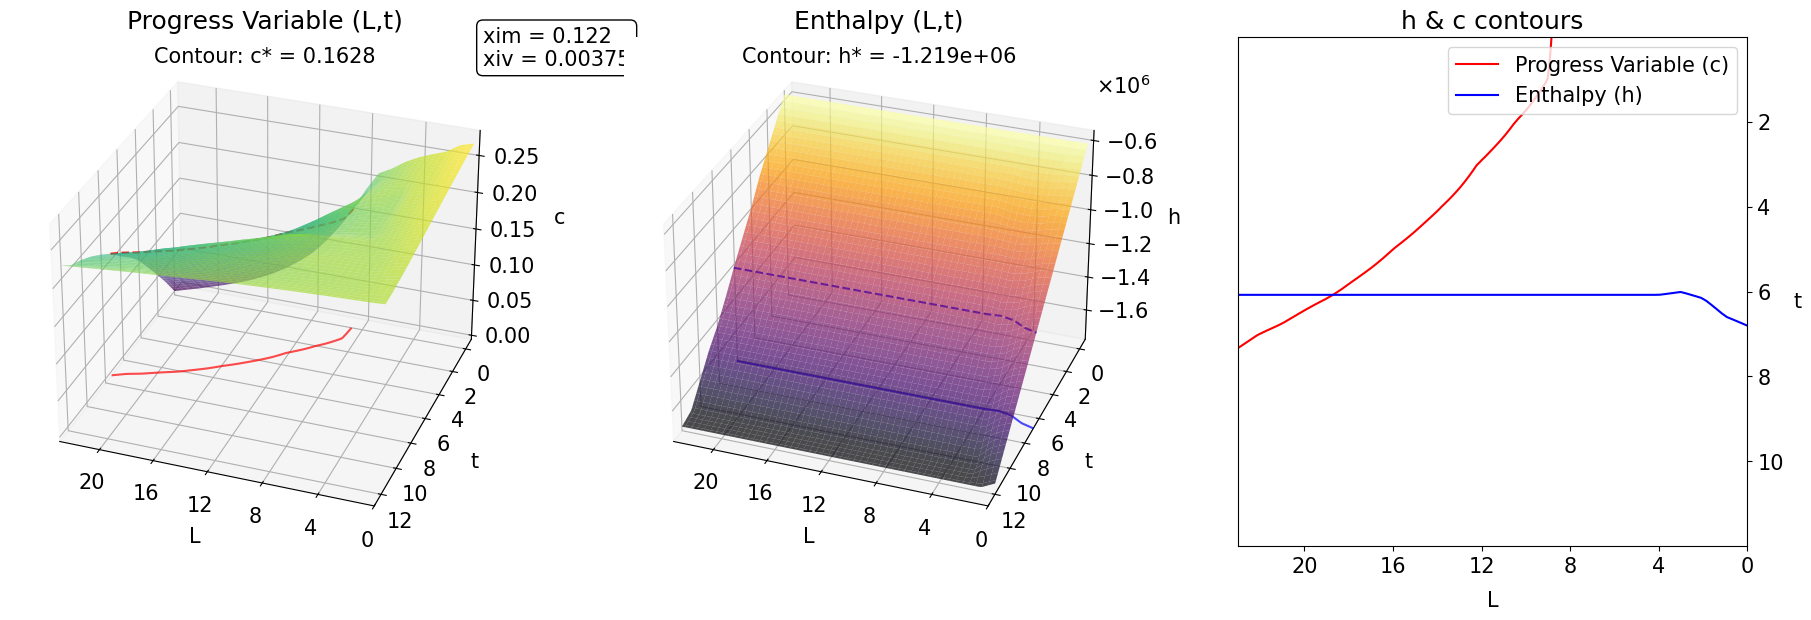

In [ ]:
#----- Plot a point from the ODT data
radLoc = 51.2 # percent through whole domain
tLoc   = 0 # percent through whole domain
radInd = int(numRads*radLoc/100)
tInd   = int(numTimes*tLoc/100)

# xim = np.abs(ODTximvals[radInd][tInd])
# xiv = np.abs(ODTxivvals[radInd][tInd])
# h   = ODThvals[radInd][tInd]
# c   = ODTcvals[radInd][tInd]
# T_ODT = ODTTvals[radInd][tInd]
#T_tablequeried = T_func[0](xim, xiv, h, c, useStoredSolution = False)[0]
xim = ximSelected
xiv = xivSelected
h   = hSelected
c   = cSelected
T_ODT = ODTTvals.T[17][500]
T_tablequeried = T_func[0](xim, xiv, h, c, useStoredSolution = False, saveSolverStates = True, 
                           LstepParams = [0.2, 0.01, 0.0075], tstepParams = [0.2, 9.5, 0.05])[0]
print("Indices:")
print(f"Radial: {radInd}")
print(f"Time  : {tInd}")
print()
print("Result:")
print(f"xim = {xim:.3g}")
print(f"xiv = {xiv:.3g}")
print(f"h   = {h:.3g}")
print(f"c   = {c:.3g}")
print(f"T_table = {T_tablequeried:.4g} K")
print(f"T_ODT   = {T_ODT:.4g} K")

#----- Create plot
hknown = hSelected
cknown = cSelected
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp, Lbounds, tbounds)
plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, Lbounds, tbounds, save = False, LtickSpacing = 4)

## Animations

### Animate over xim and xiv

In [ ]:
#----- Animate over xim and xiv
if input("Create animation over xim and xiv?")=='y':
    # Create data
    xim = 0.25
    xiv = 0.25*xim*(1-xim)

    # Create data and plot
    Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
    hknown = -4.0e6
    cknown = 0.24
    xims = np.linspace(0, 1, 10)
    xivFracs = np.linspace(0, 1, 10)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        ximInd = frame//len(xims)
        xivInd = frame%len(xims)
        print(f"Progress: {(ximInd/len(xims)+xivInd/len(xivFracs)/10)*100:.2f}%")
        xim = xims[ximInd]
        xiv = xim*(1-xim)*xivFracs[xivInd]
        Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
        plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(xims)**2, interval = 50)

    # Save the animation as a GIF
    ani.save(f"xim_xiv_Animation.gif", writer='pillow', fps=5)
    plt.ion()

### Incorrect Solve

Check vals:  0.0837402716 0.0012405055198286942 -998400.0 0.1546


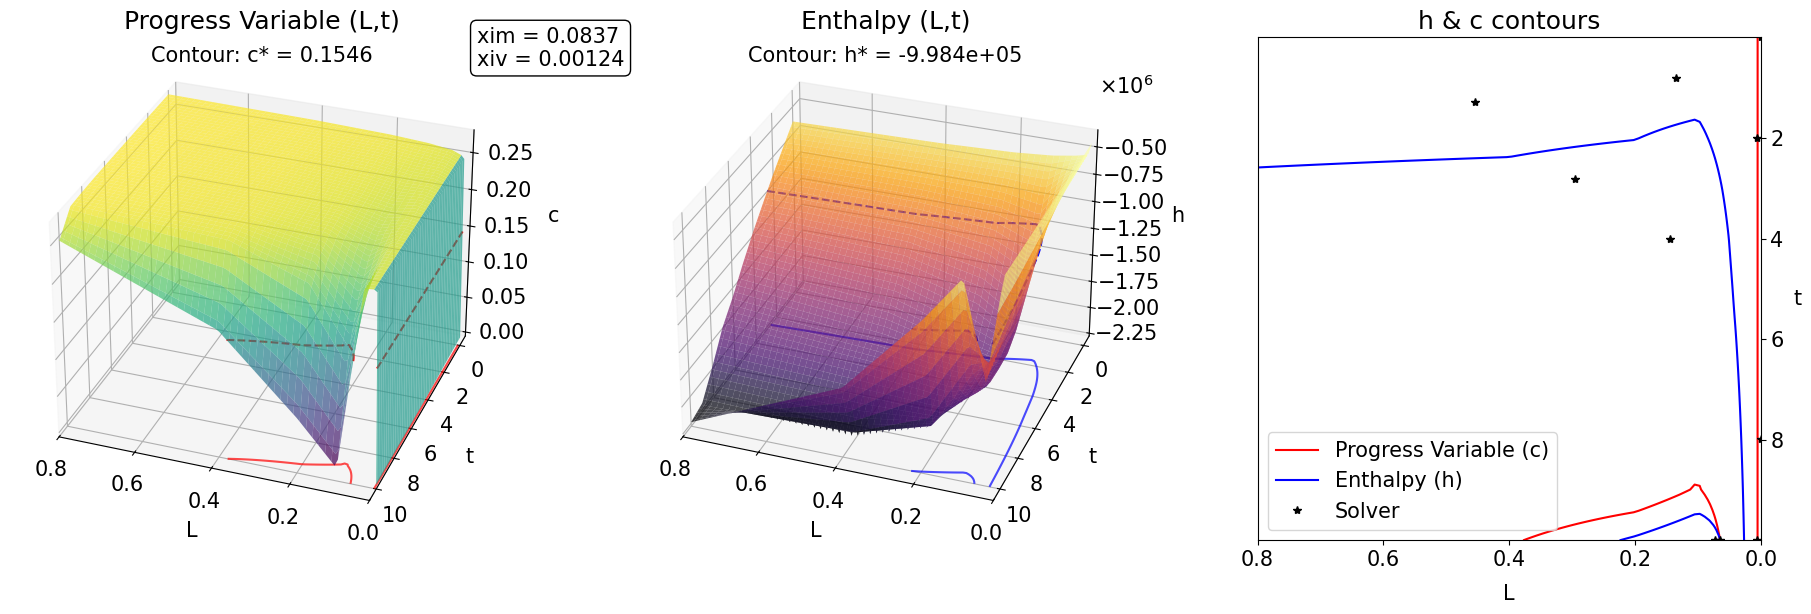

In [154]:
if input("Create animation of incorrect solve?")=='y':
    # Load in solver data
    solverDataFolder = r'./solver_data/20250121/'
    solverFilename = r'Xim_0.0837402716_Xiv_0.0012405055198286942_h_-9.984e+05_c_0.1546.txt'
    solverDataPath = solverDataFolder+solverFilename
    solverData = np.loadtxt(solverDataPath, dtype = float)

    # Parse solver data
    LSolver   = solverData[:,2]
    tSolver   = solverData[:,3]
    errSolver = solverData[:,4]

    # Parse data from file name
    pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
    matches = re.findall(pattern, solverFilename)
    solverInfo = {label: float(value) for label, value in matches}
    ximSolver = solverInfo['Xim']
    xivSolver = solverInfo['Xiv']
    hSolver   = solverInfo['h']
    cSolver   = solverInfo['c']
    print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

    # Create data and plot
    scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
    Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp, Lbounds, tbounds)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        previousPointsToShow = 10
        low = frame+1-previousPointsToShow
        if low < 0:
            low = 0
        plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, Lbounds, tbounds, scatterData[low:frame+1], save = False, fig = fig, LtickSpacing = 0.2)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

    # Save the animation as a GIF
    ani.save(f'solverAnimation_failure.gif', writer='pillow', fps=5)
    plt.ion()

### T mismatch

Check vals:  0.75 0.046875 -596200.0 0.09023


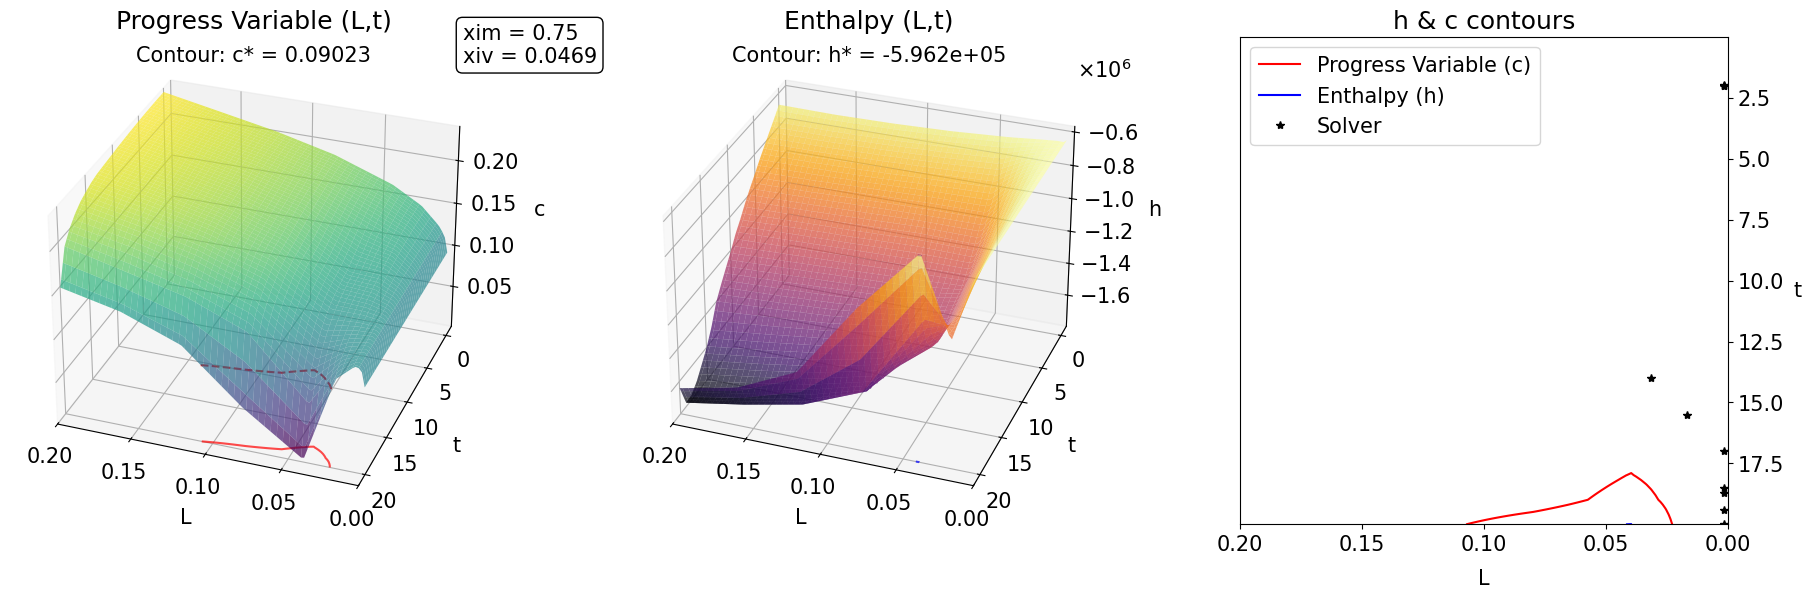

In [69]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Tmismatch/'
solverFilename = r'Xim_0.75_Xiv_0.046875_h_-5.962e+05_c_0.09023.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_Tmismatch.gif', writer='pillow', fps=5)
plt.ion()

### Correct solve

Check vals:  0.25 0.046875 -1000000.0 0.145


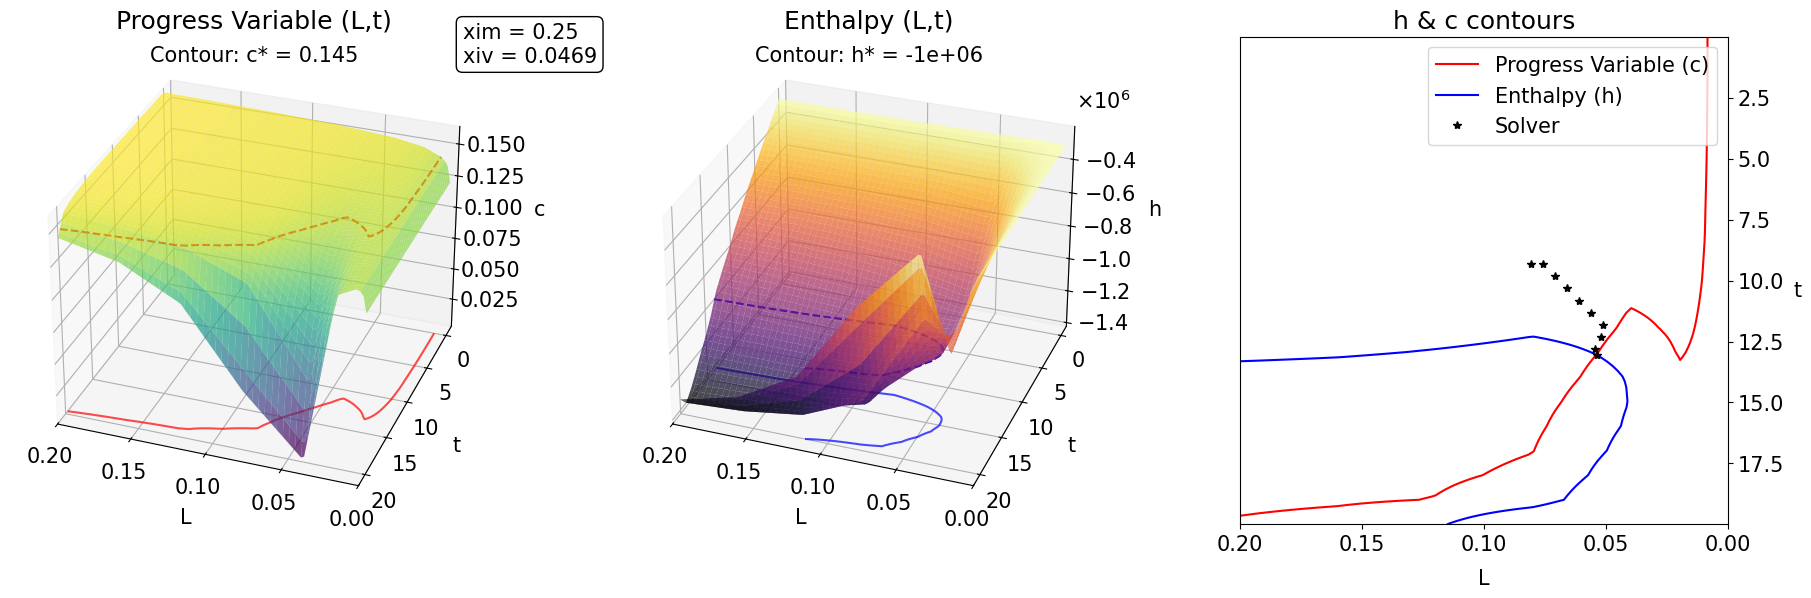

In [84]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Success/'
solverFilename = r'Xim_0.25_Xiv_0.046875_h_-1e+06_c_0.145.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_success.gif', writer='pillow', fps=5)
plt.ion()

### Animate h*, c*

In [1]:
# Create data
xim = 0.25
xiv = 0.25*xim*(1-xim)

# Create data and plot
scatterData = [[0.1, 6], [0.09, 4], [0.16, 8]]
scatterData = None
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
hknowns = np.linspace(np.max(hs), np.min(hs), 20)
cknowns = np.linspace(np.max(cs), np.min(cs), 20)


fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    if frame < len(hknowns):
        hknown = hknowns[frame]
        cknown = cknowns[4]
    else:
        hknown = hknowns[10]
        cknown = cknowns[frame-len(hknowns)]
    plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=19*2, interval = 200)

# Save the animation as a GIF
ani.save(f"hcAnimation.gif", writer='pillow', fps=5)
plt.ion()

NameError: name 'createPlotData' is not defined

# AICHE Regionals - A Priori Analysis

In [ ]:
#----- Import DOL-processed data
cols = "r, F, Frms, C, H, T, O2, N2, H2, H2O, CH4, CO, CO2, OH, NO" #from data file
ximcol = 1
xivcol = 2
hcol = 4
ccol = 3
tcol = 5

fileNames = [r"D075.Yall_proc", r"D30.Yall_proc", r"D60.Yall_proc", \
             r"D15.Yall_proc", r"D45.Yall_proc", r"D75.Yall_proc"]
filePath = r"./aPriori/processed/pmD.scat/"

# Storage arrays
t_table_data_all = np.empty(len(fileNames), dtype=np.ndarray)
data = np.empty((len(fileNames)), dtype=np.ndarray)

for j in range(len(fileNames)):                # For each file,
    netPath = filePath+fileNames[j]            # Get the path to the file,
    data[j] = np.loadtxt(netPath)[1:-1].T      # Load the file
    # NOTE: Indexing piece in the middle avoids xim=0
    t_data_table = np.ones(len(data[j][0]))*-1 # Initialize to store table-computed data
    
    for i in range(len(data[j][0])):
        xim = data[j][ximcol][i]
        xiv = data[j][xivcol][i]
        h   = data[j][hcol][i]
        c   = data[j][ccol][i]
        t_data_table[i] = T_table(xim, xiv, h, c)
    t_table_data_all[j] = t_data_table

print('done')

In [ ]:
colors = ['#FF0000', '#FFA500', '#00FF00', '#0000FF', '#4B0082', '#000000']

omit = 0 #number of plots to show simultaneously
for i in range(len(data)-omit):
    t_data_experiment = data[i][tcol]
    r = data[i][0]
    plt.plot(r, t_data_experiment, 'o', \
             color = colors[i])
    plt.plot(r, t_table_data_all[i], label = f"{fileNames[i]}", \
             color = colors[i])
plt.title("Table vs. Experiment")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Radial Position")
plt.xlim((0,75))
plt.ylim((0,2000))
plt.legend();
print("""Dots = Experimental
Lines = Table""")

# Archive - other 3D plots and animation
Old code for conceptual review

## Plotting

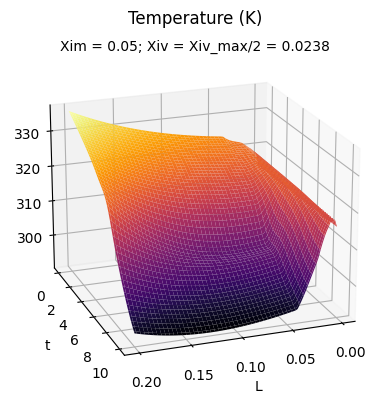

In [100]:
# Generate data
ximT = 0.05
xivT = ximT*(1-ximT)/2 #1/2 of max variance
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = It(xim, xiv, xT[i, j], yT[i, j])

# Plot data
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.view_init(20, 70)
ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, rf'Xim = {ximT:.2f}; Xiv = Xiv_max/2 = {xivT:.4f}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_xim_{ximT:.2f}_xiv_{xivT:.4f}.png',bbox_inches='tight')  # Save as a PNG file

## Animating

In [96]:
#Create Data
ximTarr = np.linspace(0.01, 0.99, 10)
xivTarr = ximTarr*(1-ximTarr)/2 #1/2 of max variance
num_points = 30
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros((len(ximTarr), len(Ls), len(ts)))

for k in range(len(ximTarr)):
    xim = ximTarr[k]
    xiv = xivTarr[k]
    print(k)
    for i in range(num_points):
        for j in range(num_points):
            Ts[k,i,j] = It(xim, xiv, xT[i, j], yT[i, j])

0
1
2
3
4
5
6
7
8
9


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  0


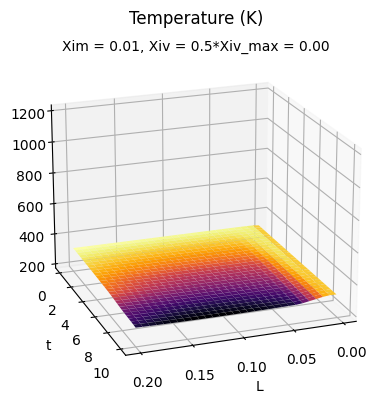

In [97]:
#Animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animData = Ts
# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(animData):
        frame = 2*len(animData)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.set_title("Temperature (K)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.view_init(20, 70)
    ax.set_zlim(bottom=np.min(animData), top=np.max(animData))
    surf = ax.plot_surface(xT, yT, animData[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {ximTarr[frame]:.2f}, Xiv = 0.5*Xiv_max = {xivTarr[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(animData), interval=200)

# Save the animation as a GIF
ani.save(f'Temperature_VariableXimXiv.gif', writer='pillow', fps=5)

## Interactive Plots

In [10]:
#----- Interactive plots
def interact1(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    contour_lines = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    contour_lines = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    
    ax.view_init(theta, phi)
    plt.show();


#wgt.interact(interact1, theta=(0,90), phi=(0,360), z)
wgt.interact(interact2, theta=(0,90), phi=(0,360), z = np.arange(0.01, 0.13, 0.01))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi, z)>